Chaves API/Tokens:
* API Key : bTqPE6hXGC48rG75ZgVe1O6pF
* API Key Secret: 1fcBpK3ztx76nq6g411t12GWdXgp1u4hSUqZJTByKgrmiteRZv

* BeaberToken:AAAAAAAAAAAAAAAAAAAAAG7o0wEAAAAAyq8C40ZKCyQrWxG1Ks1l530OAxs%3DyKGvtGA1Hv75rXZMDvZTNn5qpzDmcjHuv2LFTMyDvtZAmpMuTW

* Access Token: 1773471593223655424-UiSINXUqyA9rxXaz9k13kndeXLAaHW

* Access Token Secret : llRi53liFzasT2ToRgz3fdsAJzHJn1y461JkBNWW8C7cy

Configuração Inicial

In [ ]:
!pip install tweepy pandas matplotlib seaborn wordcloud transformers torch

Coleta de Dados

In [ ]:
import requests
import json
import time
import os
import pandas as pd

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAG7o0wEAAAAA8Uf0sexO5dfDaw4SgcWBlR6iUBE%3DtvKMzaxfin4i4ToBYKXep5imiGaL9gtKuJOPeFt0tEgP4jESIk"

headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}

params_base = {
    # ATENÇÃO AQUI - FILTRO POR BRASIL E PORTUGUÊS
    "query": '(SUS OR "saúde pública" OR vacinação) lang:pt',
    "max_results": 100,
    "tweet.fields": "created_at,public_metrics,lang,geo"
}

if os.path.exists("tweets_saude_brasil.json"):
    with open("tweets_saude_brasil.json", "r", encoding="utf-8") as f:
        all_tweets = json.load(f).get("data", [])
else:
    all_tweets = []

next_token = None

for i in range(3):
    params = params_base.copy()
    if next_token:
        params["next_token"] = next_token

    response = requests.get(
        "https://api.twitter.com/2/tweets/search/recent",
        headers=headers,
        params=params
    )

    if response.status_code == 200:
        data = response.json()
        new_tweets = data.get("data", [])
        meta = data.get("meta", {})
        next_token = meta.get("next_token")

        print(f"Página {i+1}: {len(new_tweets)} novos tweets coletados.")
        all_tweets.extend(new_tweets)

        with open("tweets_saude_brasil.json", "w", encoding="utf-8") as f:
            json.dump({"data": all_tweets}, f, indent=2, ensure_ascii=False)

        if not next_token:
            print("Não há mais páginas de tweets disponíveis.")
            break

    elif response.status_code == 429:
        reset_time = int(response.headers.get("x-rate-limit-reset", time.time() + 60))
        sleep_time = max(reset_time - time.time(), 0)
        print(f"Limite atingido. Aguardando {int(sleep_time)} segundos até reset...")
        time.sleep(sleep_time)
    else:
        print(f"Erro {response.status_code}: {response.text}")
        break

    time.sleep(2)



In [11]:
import json
import pandas as pd

data = json.load(open('tweets_saude_brasil_1.json'))
df_tweets = pd.json_normalize(data['data'])
print(df_tweets)

                                                 text lang  \
0   RT @MedicoLiberdade: VIVA O SUS !!!!  https://...   pt   
1   RT @giovanigrizotti: Na propaganda oficial, tu...   pt   
2   @JoanaLe76113478 Tristeza,  animal irracional....   pt   
3   RT @MedicoLiberdade: VIVA O SUS !!!!  https://...   pt   
4   RT @JoaquinTeixeira: Mas só aqui tem SUS 🇧🇷 ht...   pt   
..                                                ...  ...   
95  RT @giovanigrizotti: Na propaganda oficial, tu...   pt   
96  RT @Pontopontopotno: Pessoal achando que é pra...   pt   
97  RT @Pontopontopotno: Pessoal achando que é pra...   pt   
98  RT @MedicoLiberdade: VIVA O SUS !!!!  https://...   pt   
99  RT @giovanigrizotti: Na propaganda oficial, tu...   pt   

                  created_at edit_history_tweet_ids                   id  \
0   2025-05-02T00:23:40.000Z  [1918099033379254746]  1918099033379254746   
1   2025-05-02T00:23:39.000Z  [1918099027855389063]  1918099027855389063   
2   2025-05-02T00:23:36.000

Pré-processamento

In [12]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

def limpar_texto(texto):
  texto = re.sub(r'http\S+', '', texto) # remove links
  texto = re.sub(r'@[^\s]+', '', texto) # remove menções
  texto = re.sub(r'#', '', texto) # remove hashtags (mas mantém o texto)
  texto = re.sub(r'[^\w\s]', '',texto) # remove caracteres especiais
  texto = texto.lower() # converte em minúsculas
  texto = ' '.join([word for word in texto.split() if word not in stop_words])
  return texto

df_tweets['texto_limpo'] = df_tweets['text'].apply(limpar_texto)
df_tweets.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,lang,created_at,edit_history_tweet_ids,id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.bookmark_count,public_metrics.impression_count,texto_limpo
0,RT @MedicoLiberdade: VIVA O SUS !!!! https://...,pt,2025-05-02T00:23:40.000Z,[1918099033379254746],1918099033379254746,462,0,0,0,0,0,rt viva sus
1,"RT @giovanigrizotti: Na propaganda oficial, tu...",pt,2025-05-02T00:23:39.000Z,[1918099027855389063],1918099027855389063,343,0,0,0,0,0,rt propaganda oficial tudo mil maravilhas vida...
2,"@JoanaLe76113478 Tristeza, animal irracional....",pt,2025-05-02T00:23:36.000Z,[1918099013968052344],1918099013968052344,0,0,0,0,0,0,tristeza animal irracional semi selvagem deve ...
3,RT @MedicoLiberdade: VIVA O SUS !!!! https://...,pt,2025-05-02T00:23:24.000Z,[1918098966140391830],1918098966140391830,462,0,0,0,0,0,rt viva sus
4,RT @JoaquinTeixeira: Mas só aqui tem SUS 🇧🇷 ht...,pt,2025-05-02T00:23:13.000Z,[1918098917280956527],1918098917280956527,1588,0,0,0,0,0,rt aqui sus


Análise exploratória

In [18]:
import json

# Carrega os dados do arquivo JSON
with open('tweets_saude_brasil.json', 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Obtém a lista de tweets
tweets = dados.get('data', [])

# Calcula as métricas
quantidade_registros = len(tweets)
quantidade_frases = sum(len(tweet['text'].split('.')) for tweet in tweets)
tamanho_medio = sum(len(tweet['text']) for tweet in tweets) / quantidade_registros if quantidade_registros > 0 else 0

# Exibe os resultados
print(f"Quantidade de registros: {quantidade_registros}")
print(f"Quantidade de frases: {quantidade_frases}")
print(f"Tamanho médio das frases: {tamanho_medio:.2f} caracteres")

# Média de engajamento (likes, retweets, replies)
engajamento = {
    'avg_retweets': sum(tweet.get('public_metrics', {}).get('retweet_count', 0) for tweet in tweets) / max(1, len(tweets)),
    'avg_replies': sum(tweet.get('public_metrics', {}).get('reply_count', 0) for tweet in tweets) / max(1, len(tweets))
}
# Contagem de tweets com mídia (imagens/vídeos)
tweets_com_midia = sum(1 for tweet in tweets if 'media' in tweet.get('attachments', {}))
percentual_midia = (tweets_com_midia / max(1, len(tweets))) * 100

# Exibição formatada
print("\n ANÁLISE DE ENGAJAMENTO")
print("----------------------------------")
print(f" Média de retweets: {engajamento['avg_retweets']:.1f}")
print(f" Média de replies: {engajamento['avg_replies']:.1f}")
print("----------------------------------")
print(f" Total de tweets analisados: {len(tweets)}")

Quantidade de registros: 99
Quantidade de frases: 189
Tamanho médio das frases: 118.79 caracteres

 ANÁLISE DE ENGAJAMENTO
----------------------------------
 Média de retweets: 468.5
 Média de replies: 0.1
----------------------------------
 Total de tweets analisados: 99


Classificação de Sentimentos com HuggingFace Transformers

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch

# Usar GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo pré-treinado
modelo = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelo)
model = AutoModelForSequenceClassification.from_pretrained(modelo).to(device)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Aplica a análise
df_tweets['sentimento'] = df_tweets['texto_limpo'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label']) # limitando texto em 512 caracteres

df_tweets

Device set to use cpu


,text,lang,created_at,edit_history_tweet_ids,id,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.bookmark_count,public_metrics.impression_count,texto_limpo,sentimento
0,RT @MedicoLiberdade: VIVA O SUS !!!! https://...,pt,2025-05-02T00:23:40.000Z,[1918099033379254746],1918099033379254746,462,0,0,0,0,0,rt viva sus,LABEL_1
1,"RT @giovanigrizotti: Na propaganda oficial, tu...",pt,2025-05-02T00:23:39.000Z,[1918099027855389063],1918099027855389063,343,0,0,0,0,0,rt propaganda oficial tudo mil maravilhas vida...,LABEL_1
2,"@JoanaLe76113478 Tristeza, animal irracional....",pt,2025-05-02T00:23:36.000Z,[1918099013968052344],1918099013968052344,0,0,0,0,0,0,tristeza animal irracional semi selvagem deve ...,LABEL_1
3,RT @MedicoLiberdade: VIVA O SUS !!!! https://...,pt,2025-05-02T00:23:24.000Z,[1918098966140391830],1918098966140391830,462,0,0,0,0,0,rt viva sus,LABEL_1
4,RT @JoaquinTeixeira: Mas só aqui tem SUS 🇧🇷 ht...,pt,2025-05-02T00:23:13.000Z,[1918098917280956527],1918098917280956527,1588,0,0,0,0,0,rt aqui sus,LABEL_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"RT @giovanigrizotti: Na propaganda oficial, tu...",pt,2025-05-02T00:08:54.000Z,[1918095317154582768],1918095317154582768,343,0,0,0,0,0,rt propaganda oficial tudo mil maravilhas vida...,LABEL_1
96,RT @Pontopontopotno: Pessoal achando que é pra...,pt,2025-05-02T00:08:51.000Z,[1918095304114548851],1918095304114548851,1283,0,0,0,0,0,rt pessoal achando pra abater fazer nugget sen...,LABEL_1
97,RT @Pontopontopotno: Pessoal achando que é pra...,pt,2025-05-02T00:08:25.000Z,[1918095194861326413],1918095194861326413,1283,0,0,0,0,0,rt pessoal achando pra abater fazer nugget sen...,LABEL_1
98,RT @MedicoLiberdade: VIVA O SUS !!!! https://...,pt,2025-05-02T00:08:17.000Z,[1918095159092261022],1918095159092261022,462,0,0,0,0,0,rt viva sus,LABEL_1


Visualização de Resultados

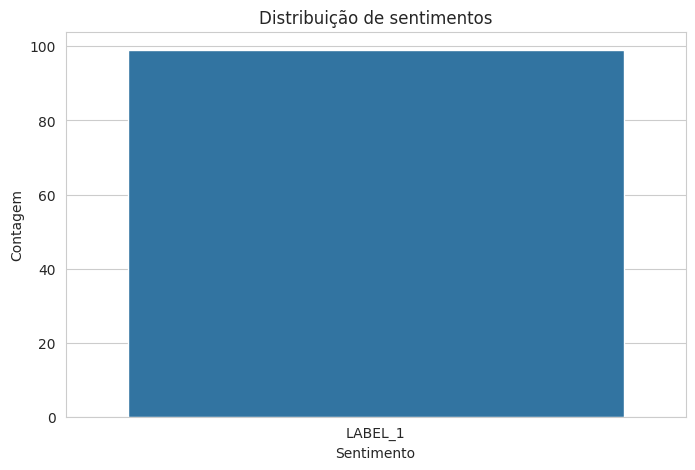

In [10]:
# Gráfico de barras dos sentimentos
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='sentimento', data=df_tweets, order=df_tweets['sentimento'].value_counts().index)
plt.title("Distribuição de sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Contagem")
plt.show()